# Do the same thing for the UDF_f105w.fits file as for the sep_tutorial

In [31]:
import sep
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from matplotlib.patches import Ellipse
from astropy import visualization as vis
%matplotlib inline

In [32]:
f105w = download_file('https://archive.stsci.edu/pub/hlsp/hudf12/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
hdul = fits.open(f105w)
data = hdul[0].data
hdul.close()

In [33]:
# I will define functions for everything to make the code as compressible as possible.
# This function will do a basic plot of the FITS file
def FITS_plotter(array,figsz,interpol,cmp,orig,save_file_name):
    m, s = np.mean(array), np.std(data)
    plt.figure(figsize=figsz)
    plt.imshow(array, interpolation=interpol, cmap=cmp, vmin=m-s, vmax=m+s, origin=orig)
    plt.colorbar()
    plt.savefig(save_file_name);

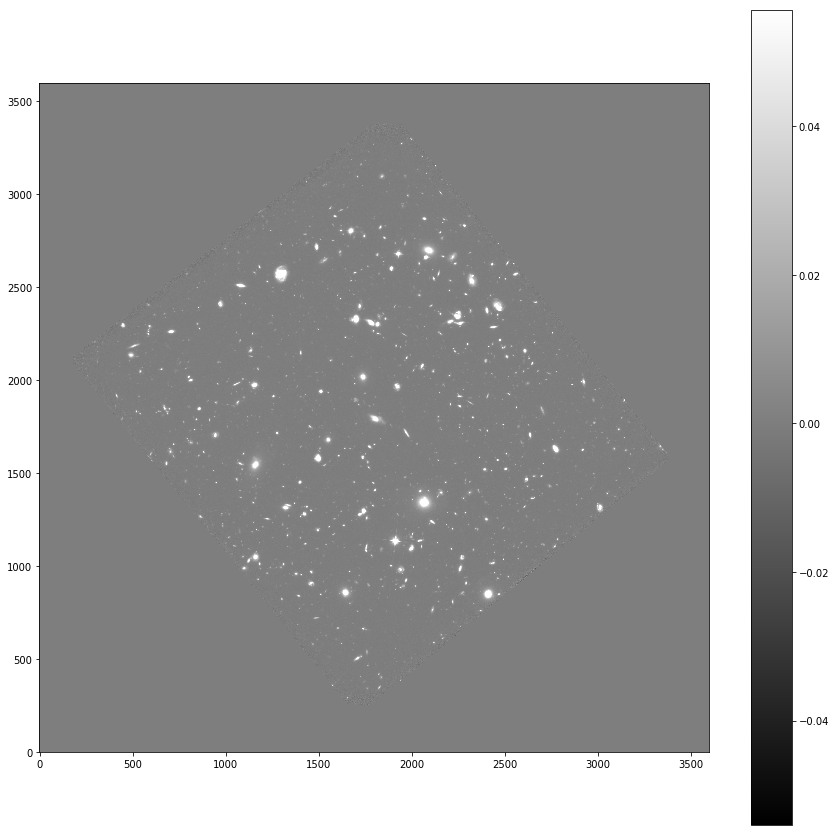

In [34]:
FITS_plotter(data,(15,15),'nearest','gray','lower','f105w_direct.png')

## Background Subtraction and Object Detection

In [35]:
data = data.byteswap(inplace=True).newbyteorder()

In [36]:
# Create a function containing all of the data needed for the background
# subtraction and object detection.
def Object_Data():
    
    # Define the variables that will be used in a class later as global
    global v, bkg, bkg_back, bkg_rms, gback, grms, data_sub, adata_sub, aobjects, sxt, aflux, afluxerr, aflag
    
    # This will be used to provide for the m, s in the plots and for the background
    # and rms images.
    bkg = sep.Background(data, bw=16, bh=16)
    data_sub = data - bkg
    bkg_back = bkg.back()
    bkg_rms = bkg.rms()
    
    # The data will be turned into integer slices
    ndata = {}
    v = 0
    for i in range(36):
        for n in range(36):
            ndata[36*i + n] = data[100*i:100*i+100:1,100*n:100*n+100:1]
            v += 1
    
    # This line converts the dict to an array
    adata = np.array(list(ndata.values()))
    
    # This section will define the values for the global background, global rms, and the data
    # array with the background subtracted.
    ndata_sub = {}
    gback = {}
    grms = {}
    for i in range(v):
        ndata_sub[i] = adata[i] - sep.Background(adata[i], bw=32, bh=32)
        gback[i] = sep.Background(adata[i], bw=32, bh=32).globalback
        grms[i] = sep.Background(adata[i], bw=32, bh=32).globalrms
    adata_sub = np.array(list(ndata_sub.values()))

    # Convert the gback and grms dicts into arrays
    agback = np.array(list(gback.values()))
    agrms = np.array(list(grms.values()))
    
    # Take the average of all of the relevant grms values
    u = 0
    for i in range(v):
        if(agrms[i]==1):
            u += 1
        else:
            continue
    Avg_agrms = (sum(agrms)-u)/(v-u)
                    
    # Place the raw sep.extract data into the sxt dict and the len(sep.extract) data into an objects dict
    objects = {}
    sxt = {}
    for i in range(v):
        try:
            p = np.exp(agrms[i]/Avg_agrms)
        except:
            p = 1
        q = sep.extract(adata_sub[i], p, err=sep.Background(adata[i], bw=32, bh=32).globalrms)
        sxt[i] = sep.extract(adata_sub[i], p, err=sep.Background(adata[i], bw=32, bh=32).globalrms)
        if(len(q)>30):
            q = sep.extract(adata_sub[i], 30*p, err=sep.Background(adata[i], bw=32, bh=32).globalrms)
        objects[i] = len(q)
    aobjects = np.array(list(objects.values()))
    
    dflux = {}
    dfluxerr = {}
    dflag = {}

    for n in range(1296):
        dflux[n], dfluxerr[n], dflag[n] = sep.sum_circle(adata_sub[n],sxt[n]['x'],sxt[n]['y'],np.exp(agrms[n]/Avg_agrms)\
                                                     ,err=agrms[n], gain=1.0)

    aflux = np.array(list(dflux.values()))
    afluxerr = np.array(list(dfluxerr.values()))
    aflag = np.array(list(dflag.values()))
    # Return the arrays and values
    return v, gback, grms, data_sub, adata_sub, aobjects, sxt, aflux, afluxerr, aflag

In [37]:
# Now to define a class containing all of the functions that will be used for object
# detection.
class Object_Detection():
    def printer():
        Object_Data()
        for i in range(v):
            print('i:',i)
            print('\t','Global background:',gback[i])
            print('\t','Global rms:       ',grms[i])
            
    # Since plot_back and plot_rms don't need to be sliced, bkg.back and bkg.rms will
    # be plotted.
    def plot_back(figsz,interpol,cmp,orig,save_file_name):
        Object_Data()
        plt.figure(figsize=figsz)
        plt.imshow(bkg_back, interpolation=interpol, cmap=cmp, origin=orig)
        plt.colorbar()
        plt.savefig(save_file_name)
                      
    def plot_rms(figsz,interpol,cmp,orig,save_file_name):
        Object_Data()
        plt.figure(figsize=figsz)
        plt.imshow(bkg_rms, interpolation=interpol, cmap=cmp, origin=orig)
        plt.colorbar()
        plt.savefig(save_file_name)
        
    def object_detector(figsz,interpol,cmp,orig,save_file_name):
        Object_Data()
        im = {}
        fig, ax = plt.subplots(ncols=36, nrows=36, figsize=figsz)
        fig.subplots_adjust(hspace=0, wspace=0)
        w = 0
        z = 0
        m, s = np.mean(data_sub), np.std(data_sub)
        for n in range(v):
            im[n] = ax[36-z-1,w].imshow(adata_sub[n], interpolation=interpol, cmap=cmp, vmin=m-s, vmax=m+s, origin=orig)
            ax[36-z-1,w].axis('off')
    
            if(aobjects[n]>=25):
                if(w==36-1):
                    w = 0
                    z += 1
                else:
                    w += 1
            else:
                for i in range(aobjects[n]):
                    try:
                        if(aflux[n][i]<=0.05):
                            continue
                        else:
                            try:
                                e = Ellipse(xy=(sxt[n]['x'][i], sxt[n]['y'][i]),width=6*sxt[n]['a'][i],height=6*sxt[n]['b'][i],\
                                            angle=sxt[n]['theta'][i]*180/(2*np.pi))
                            except:
                                continue
                            e.set_facecolor('none')
                            e.set_edgecolor('red')
                            ax[35-z,w].add_artist(e)
                    except:
                        try:
                            e = Ellipse(xy=(sxt[n]['x'][i], sxt[n]['y'][i]),width=6*sxt[n]['a'][i],height=6*sxt[n]['b'][i],\
                                angle=sxt[n]['theta'][i]*180/(2*np.pi))
                        except:
                            continue
                        e.set_facecolor('none')
                        e.set_edgecolor('red')
                        ax[35-z,w].add_artist(e)
                if(w==36-1):
                    w = 0
                    z += 1
                else:
                    w += 1
        plt.savefig(save_file_name)

In [38]:
# Now that the class is defined, lets start with the printer function.
Object_Detection.printer()

C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


i: 0
	 Global background: 0.0
	 Global rms:        1.0
i: 1
	 Global background: 0.0
	 Global rms:        1.0
i: 2
	 Global background: 0.0
	 Global rms:        1.0
i: 3
	 Global background: 0.0
	 Global rms:        1.0
i: 4
	 Global background: 0.0
	 Global rms:        1.0
i: 5
	 Global background: 0.0
	 Global rms:        1.0
i: 6
	 Global background: 0.0
	 Global rms:        1.0
i: 7
	 Global background: 0.0
	 Global rms:        1.0
i: 8
	 Global background: 0.0
	 Global rms:        1.0
i: 9
	 Global background: 0.0
	 Global rms:        1.0
i: 10
	 Global background: 0.0
	 Global rms:        1.0
i: 11
	 Global background: 0.0
	 Global rms:        1.0
i: 12
	 Global background: 0.0
	 Global rms:        1.0
i: 13
	 Global background: 0.0
	 Global rms:        1.0
i: 14
	 Global background: 0.0
	 Global rms:        1.0
i: 15
	 Global background: 0.0
	 Global rms:        1.0
i: 16
	 Global background: 0.0
	 Global rms:        1.0
i: 17
	 Global background: 0.0
	 Global rms:        1.0
i:

	 Global rms:        1.0
i: 242
	 Global background: 0.0
	 Global rms:        1.0
i: 243
	 Global background: 0.0
	 Global rms:        1.0
i: 244
	 Global background: 0.0
	 Global rms:        1.0
i: 245
	 Global background: 0.0
	 Global rms:        1.0
i: 246
	 Global background: 0.0
	 Global rms:        1.0
i: 247
	 Global background: 0.0
	 Global rms:        1.0
i: 248
	 Global background: 0.0
	 Global rms:        1.0
i: 249
	 Global background: 0.0
	 Global rms:        1.0
i: 250
	 Global background: 0.0
	 Global rms:        1.0
i: 251
	 Global background: 0.0
	 Global rms:        1.0
i: 252
	 Global background: 0.0
	 Global rms:        1.0
i: 253
	 Global background: 0.0
	 Global rms:        1.0
i: 254
	 Global background: 0.0
	 Global rms:        1.0
i: 255
	 Global background: 0.0
	 Global rms:        1.0
i: 256
	 Global background: 0.0
	 Global rms:        1.0
i: 257
	 Global background: 0.0
	 Global rms:        1.0
i: 258
	 Global background: 0.0
	 Global rms:        1.0
i: 259

	 Global rms:        0.0005856461939401925
i: 492
	 Global background: -0.00016687411698512733
	 Global rms:        0.0004985480918549001
i: 493
	 Global background: -0.00010012301936512813
	 Global rms:        0.000528007629327476
i: 494
	 Global background: -9.710896847536787e-05
	 Global rms:        0.0005312684224918485
i: 495
	 Global background: 2.251456862722989e-06
	 Global rms:        0.0004809419042430818
i: 496
	 Global background: -2.9484050173778087e-05
	 Global rms:        0.0005241899634711444
i: 497
	 Global background: 2.3868729840614833e-05
	 Global rms:        0.0005989123601466417
i: 498
	 Global background: 0.00025228451704606414
	 Global rms:        0.0009833776857703924
i: 499
	 Global background: 0.0
	 Global rms:        0.0008642912143841386
i: 500
	 Global background: 0.0
	 Global rms:        1.0
i: 501
	 Global background: 0.0
	 Global rms:        1.0
i: 502
	 Global background: 0.0
	 Global rms:        1.0
i: 503
	 Global background: 0.0
	 Global rms:       

	 Global rms:        0.0005078846588730812
i: 742
	 Global background: -5.092454011901282e-05
	 Global rms:        0.0005212712567299604
i: 743
	 Global background: -8.148502092808485e-05
	 Global rms:        0.0005344090168364346
i: 744
	 Global background: -0.00011747174721676856
	 Global rms:        0.0005269082030281425
i: 745
	 Global background: -2.9757984520983882e-05
	 Global rms:        0.0005457096849568188
i: 746
	 Global background: -4.586828072206117e-05
	 Global rms:        0.0005346608813852072
i: 747
	 Global background: -9.546817454975098e-05
	 Global rms:        0.0005225277272984385
i: 748
	 Global background: -6.343200948322192e-05
	 Global rms:        0.0005306124221533537
i: 749
	 Global background: 2.4408551325905137e-05
	 Global rms:        0.0007855651201680303
i: 750
	 Global background: 0.0
	 Global rms:        0.0011680652387440205
i: 751
	 Global background: 0.0
	 Global rms:        1.0
i: 752
	 Global background: 0.0
	 Global rms:        1.0
i: 753
	 Globa

	 Global background: 0.0003585944068618119
	 Global rms:        0.0005881867255084217
i: 992
	 Global background: 0.0005971660139039159
	 Global rms:        0.0005908829625695944
i: 993
	 Global background: 0.000647246721200645
	 Global rms:        0.0005663392948918045
i: 994
	 Global background: 0.00017825439863372594
	 Global rms:        0.0005160982254892588
i: 995
	 Global background: 5.884327765670605e-05
	 Global rms:        0.0007555587217211723
i: 996
	 Global background: 0.0
	 Global rms:        0.0010494585148990154
i: 997
	 Global background: 0.0
	 Global rms:        1.0
i: 998
	 Global background: 0.0
	 Global rms:        1.0
i: 999
	 Global background: 0.0
	 Global rms:        1.0
i: 1000
	 Global background: 0.0
	 Global rms:        1.0
i: 1001
	 Global background: 0.0
	 Global rms:        1.0
i: 1002
	 Global background: 0.0
	 Global rms:        1.0
i: 1003
	 Global background: 0.0
	 Global rms:        1.0
i: 1004
	 Global background: 0.0
	 Global rms:        1.0
i: 100

	 Global background: 0.0
	 Global rms:        1.0
i: 1242
	 Global background: 0.0
	 Global rms:        1.0
i: 1243
	 Global background: 0.0
	 Global rms:        1.0
i: 1244
	 Global background: 0.0
	 Global rms:        1.0
i: 1245
	 Global background: 0.0
	 Global rms:        1.0
i: 1246
	 Global background: 0.0
	 Global rms:        1.0
i: 1247
	 Global background: 0.0
	 Global rms:        1.0
i: 1248
	 Global background: 0.0
	 Global rms:        1.0
i: 1249
	 Global background: 0.0
	 Global rms:        1.0
i: 1250
	 Global background: 0.0
	 Global rms:        1.0
i: 1251
	 Global background: 0.0
	 Global rms:        1.0
i: 1252
	 Global background: 0.0
	 Global rms:        1.0
i: 1253
	 Global background: 0.0
	 Global rms:        1.0
i: 1254
	 Global background: 0.0
	 Global rms:        1.0
i: 1255
	 Global background: 0.0
	 Global rms:        1.0
i: 1256
	 Global background: 0.0
	 Global rms:        1.0
i: 1257
	 Global background: 0.0
	 Global rms:        1.0
i: 1258
	 Global backg

C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


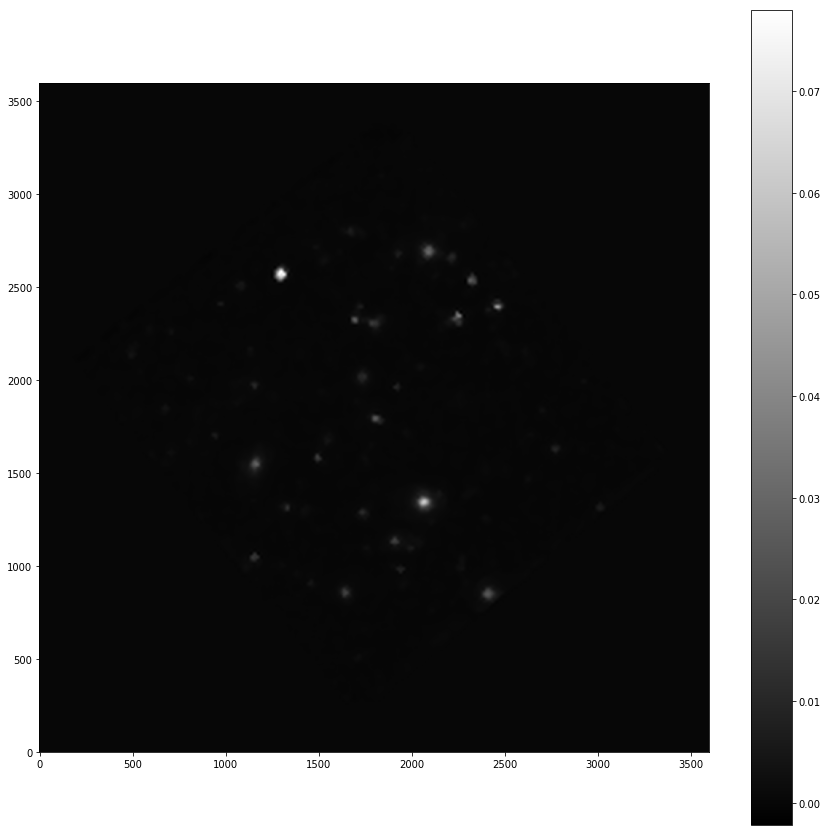

In [39]:
# Now for the background image
Object_Detection.plot_back((15,15),'nearest','gray','lower','f105w_back.png')

C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


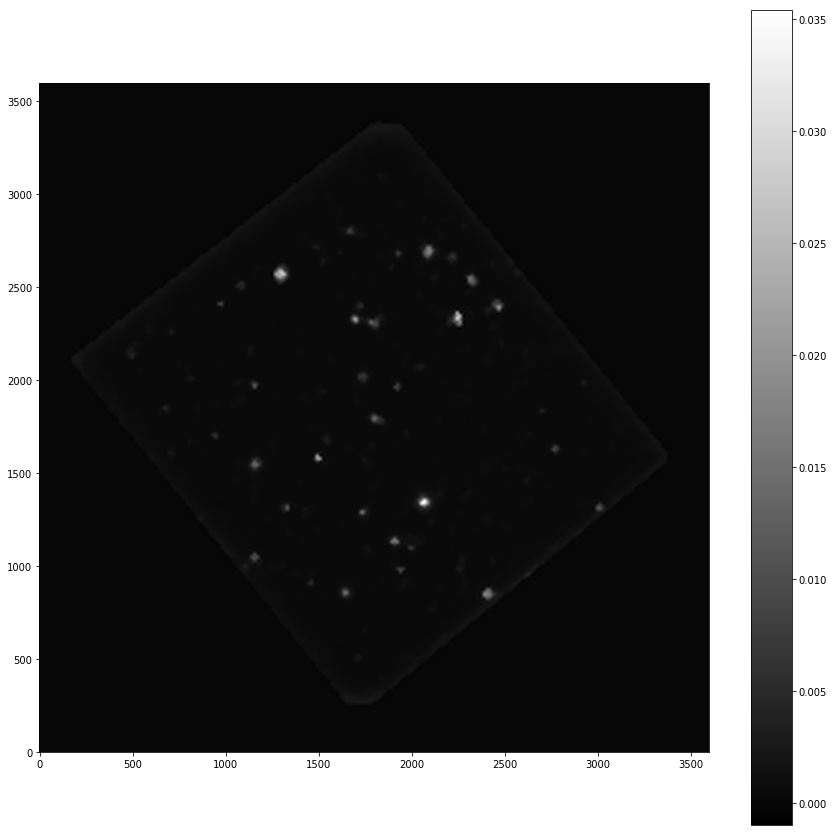

In [40]:
Object_Detection.plot_rms((15,15),'nearest','gray','lower','f105w_rms.png')

In [ ]:
Object_Detection.object_detector((15,15),'nearest','gray','lower','f105w_final.png')

C:\Users\hitom\Anaconda3\envs\bash\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


### There are 2526 objects in this image, with uncertainty due to high noise around the border, the same objects being detected multiple times on slice boundaries, and the inability to differentiate low noise from especially faint objects in certain regions.

## Aperature Photometry and HIstogram

In [ ]:
Object_Data()
fluxes = np.concatenate(aflux)
fluxerrs = np.concatenate(afluxerr)
flags = np.concatenate(aflag)

In [ ]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i,fluxes[i],fluxerrs[i]))

### There is a difference between the number of objects and the number of fluxes as shown below. This is likely due to the detection of an object multiple times along the boundaries of the slices.

In [ ]:
print('Fluxes: ',len(fluxes))
print('Objects:',np.sum(aobjects))

In [ ]:
# The main plot is all of the fluxes, while the image at the top right is a magnification of the bottom left corner.
# This is done to give a better view of the low flux values that are otherwise unseen due to the high fluxes.
ax1 = plt.figure(figsize=(15,15)), plt.axes()
ax1 = vis.hist(fluxes,5092,range=(0,5))
ax2 = plt.axes([0.55, 0.55, 0.3, 0.3])
ax2 = vis.hist(fluxes,5092,range=(0,1))